In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from misc_tools.print_latex import print_tex
from collections import defaultdict
from matplotlib import cm
from tqdm import tqdm

input example : 
>>> arr_T = np.array([[r'\vec{v}_1', r'\vec{v}_2']]).T
>>> print_tex(arr_T,'=', np.arange(1,5).reshape(2,-1)/4, r'; symbols: \otimes, \cdot,\times')
output: 


<IPython.core.display.Math object>

***
*   For systems where system dynamics is not available we cannot use Bellman equations to derive state values.

*   Monte Carlo (MC) is a method that avoids knowing system dynamics by computing estimates based on many samples.

*   For example this is a method that use Dynamic Programming (DP) for estimating Markov Decision Process'es (MDP) optimal state values:

    $$v_{\ast}^{k+1}(s) = \underset{a \in A}{\mathrm{max}} \ q_{\ast}(s,a) = \underset{a \in A}{\mathrm{max}} \ \sum_{r \in R} \sum_{s^\prime \in S} p(s^\prime, r|s,a) \cdot \biggl[ r + \gamma \cdot v_{\ast}^{k}(s^\prime)\biggr]$$ 

    It is reliant on knowing system dynamics $p(s^\prime,r|s,a)$ and makes an estimate of $v_{\ast}^{k+1}(s)$ based on previous estimates for neighboring states $v_{\ast}^{k}(s^\prime)$.

    Making estimates based on estimates is called "bootstrapping". Disadvantages of bootstrapping is that poor quality of prior estimate can degrade result of update rule.

*   MC, instead, can be "released" on a specific state (node), explore possible transitions, and extract particular state value without need to know state values of its neighbors.

*   Without a system model we can estimate action (state-action pair) values $q_\pi(s,a)$, since greedy policy can be extracted via
    $$\pi(s) = \underset{a \in A(s)}{\mathrm{argmax}} \ q_{\pi}(s,a)$$

*   That model would work, but only under specific condition: that we were to sample all possible <b>state-action pair starts</b>.

    This approach is called <i>Exploring Starts (ES)</i>.
    
    Under EC MC we can expect MC to visit all possible $(s,a)$ combinations given that we record many episodes.

    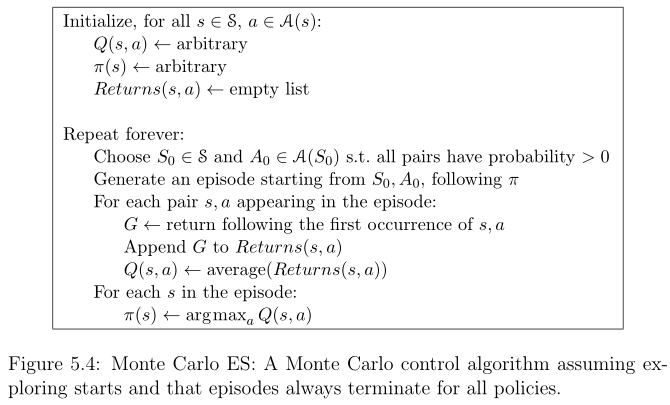
    
*   In real application use of EC MC is often impossible, so we should introduce a policy that allows for some exploration. 

    Additionally, we can transform this method to problem of Control, by shaping policy to be greedy with respect to latest $q(s,a)$. 
    
    Yet, we keep $\epsilon$ stochastisity for non-greedy actions to keep exploring.

    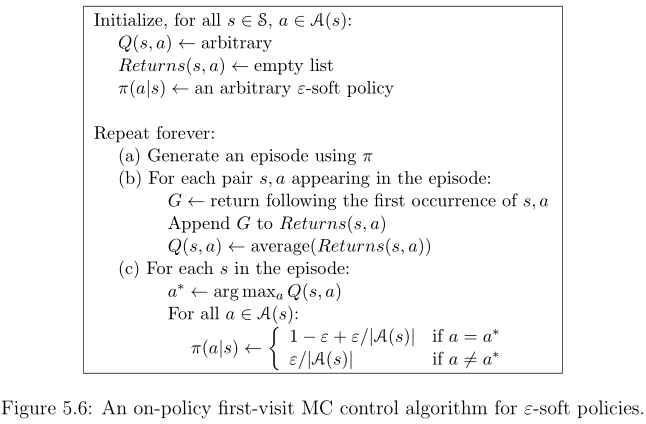


*   Term <i>First-visit</i> means that if during one episode agent returns to previously visited state, we dont include rewards related to later visits into average.

    <i>Every-visit</i> does include all rewards from repeated visits into average.
    
*   <i>on-policy</i> means that algorithm forms expectation of $q(s,a)$ based on current policy. 
    
    While this sounds like obvious and only meaningful strategy, later we will see that its not the only way (<i>off-policy</i>). 
    
    In fact, we can learn $q_\pi(s,a)$, for some policy $\pi$, based on episodes which resulted by following some other policy $\mu$.
    
    It is done by using <i>Importance Sampling</i> theorem.

*   We will also see the term <i>Incremental</i> which will refer to updates to policy being made one-episode basis, not a batch-of-episodes basis.

    More extreme version is <i>Online</i> in which adjustments are made before reaching episode end. But its not used in MC algorithms.

<b>Resources: </b>

* book
* https://www.youtube.com/watch?v=PnHCvfgC_ZA
* https://ai.stackexchange.com/questions/10812/what-is-the-difference-between-first-visit-monte-carlo-and-every-visit-monte-car

In [33]:
class init_env():
    def __init__(self, env_name, *args, eps = 0.1, seed = 69, **kwargs) -> None:
        np.random.seed(seed)
        self.env                    = gym.make(env_name, *args, **kwargs)
        self.STATE_SHAPE            = tuple(map(lambda x: x.n, self.env.observation_space))
        self.NUM_ACTIONS            = self.env.action_space.n # 0 = stick. 1 = hit
        self.STATE_SHAPE_EXTENDED   = self.STATE_SHAPE + (self.NUM_ACTIONS,)
        self.NUM_STATES_TOTAL       = np.prod(self.STATE_SHAPE)
        self.actions                = np.arange(self.NUM_ACTIONS)
        self.eps                    = eps
        self.policy                 = np.ones(shape= self.STATE_SHAPE_EXTENDED)
        self.num_state_visits       = defaultdict(int)
        
    def get_policy_soft(self, eps = None):
        if eps is None: eps = self.eps
        # define base epsilon-soft policy. 1) fill with eps values;2) fill greedy values
        self.policy = self.policy.reshape((-1,self.NUM_ACTIONS))*eps/(self.NUM_ACTIONS)
        num_states  = len(self.policy)
        greedy      = np.random.randint(0, self.NUM_ACTIONS, size = (num_states,))
        self.policy[np.arange(num_states),greedy] = (1-eps + eps/(self.NUM_ACTIONS))
        self.policy = self.policy.reshape(self.STATE_SHAPE_EXTENDED)
        return self.policy

    def get_Qsa(self, random = False, val = 0.5):
        if not random:
            self.Qsa = np.ones(self.STATE_SHAPE_EXTENDED)*val # hand, opp card, usable ace, action
        else:
            self.Qsa = np.random.randn(*self.STATE_SHAPE_EXTENDED)
        return self.Qsa
    
    def get_policy_Qsa_greedy(self):
        self.policy = np.argmax(self.Qsa, axis=-1) 
        return self.policy
    
    def sample_action_policy(self, state):
        return np.random.choice(self.actions, p= self.policy[state])
    
    def best_action(self, state):
        q_vals = self.Qsa[state]
        return np.random.choice(np.where(q_vals == q_vals.max())[0])
    
    def update_policy_soft(self, state, action_greedy):
        self.policy[state]                  = np.ones(self.NUM_ACTIONS)*self.eps/(self.NUM_ACTIONS)
        self.policy[state][action_greedy]   = (1-self.eps + self.eps/(self.NUM_ACTIONS))     
        
    def state_remap(self,state):
        if len(state) > 1:  return tuple(map(int,state))
        else:               return (int(state),)
    
    def reset(self):
        state = self.env.reset()[0]
        return self.state_remap(state)
    
    def step(self, action):
        state, reward, done = self.env.step(action)[:3]
        state               = self.state_remap(state)
        return state, reward, done


In [42]:
def plot(v_ace, v_ace_no, pol_ace, pol_ace_no, extent, lables1 = None, lables2 = None):
    xmin,xmax,ymin,ymax = extent
    fig, ax = plt.subplots(2, 2, figsize=(10, 8), subplot_kw={'projection': '3d'})
    sx,sy = slice(xmin,xmax),slice(ymin,ymax)
    X, Y = np.meshgrid(np.arange(v_ace.shape[0]), np.arange(v_ace.shape[1]), indexing='ij')

    if lables1 is None: lables1= ['V(s) Usable Ace','V(s) No Usable Ace']
    for i,Z,t in zip([0,1],[v_ace,v_ace_no],lables1):
        ax[0,i].set_title(t)
        ax[0,i].plot_surface(X[sx,sy], Y[sx,sy], Z[sx,sy], cmap=cm.coolwarm, linewidth=5, antialiased=True)
        ax[0,i].view_init(ax[0,0].elev, -145)
        ax[0,i].set_xlabel('Dealer\'s Showing Card')
        ax[0,i].set_ylabel('Player\'s Current Sum')
        ax[0,i].set_zlabel('State Value')
        ax[0,i].set_box_aspect((1,1,0.2))
        ax[0,i].grid(False)
        ax[0,i].set_zticks([])

    if lables2 is None: lables2= ['$\pi$(s) Ace','$\pi$(s) no Ace']   
    for i, Z, t in zip([0,1],[pol_ace, pol_ace_no],lables2):
        ax[1, i].remove()
        ax[1, i] = fig.add_subplot(2, 2, i + 3)
        ax[1,i].set_title(t)
        ax[1,i].matshow(Z[sx,sy], cmap=cm.coolwarm, extent= [ymin-0.5,ymax+0.5,xmin-0.5,xmax+0.5])#
        ax[1,i].invert_yaxis()
        ax[1,i].set_aspect(1)
        


In [60]:
def update_mean_single(arr_a_mean, arr_a_len, val):
    return 1/(arr_a_len+1) * (arr_a_len*arr_a_mean + val)

def on_policy_first_visit_MC(env: init_env, N = 1, gamma = 1):

    for _ in tqdm(range(N)):
        state   = env.reset()
        trajectory  = []
        rewards     = []
        first_time  = {}
        i = 0
        while True:
            action = env.sample_action_policy(state)
            state_action        = state + (action,)
            state, reward, done = env.step(action)
            trajectory.append(state_action)
            rewards.append(reward)
            if state_action not in first_time: first_time[state_action] = i
            i += 1
            if done: break
        
        w = ([gamma]*len(rewards))**np.arange(len(rewards)) # [g^0, g^1,...]
        rewards *= w

        for state_action, start_index in first_time.items():
            mean_reward = np.sum(rewards[start_index:]) 
            env.Qsa[state_action] = update_mean_single(env.Qsa[state_action], env.num_state_visits[state_action], mean_reward)

            env.num_state_visits[state_action] += 1
            
        for state_action in trajectory:
            state = state_action[:-1]
            best_action = env.best_action(state)
            env.update_policy_soft(state, best_action)

    return



  0%|          | 0/100000 [00:00<?, ?it/s]

c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 100000/100000 [00:45<00:00, 2195.61it/s]


In [59]:
BJ = init_env('Blackjack-v1', sab=True)
BJ.get_policy_soft()
BJ.get_Qsa(random = False, val = 0.5);

100%|██████████| 3000000/3000000 [23:18<00:00, 2145.60it/s]


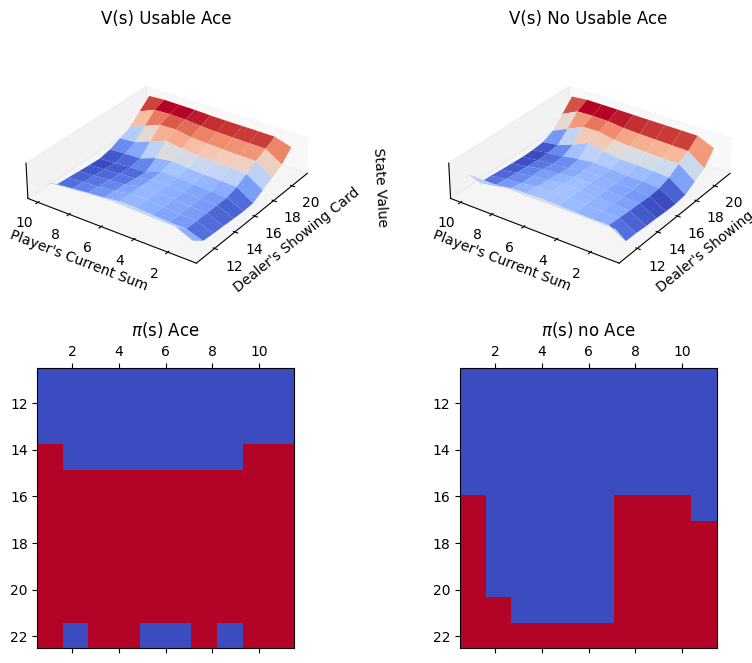

In [65]:
on_policy_first_visit_MC(BJ,3_000_000)
vp = BJ.Qsa.max(axis = -1)
min_hand = 11; max_hand = 22; min_deal = 1; max_deal = 11
v_ace, v_ace_no = vp[:,:,0],vp[:,:,1]

pol_ace_no     = np.argmax(BJ.policy, axis=-1)[:,:,0]
pol_ace        = np.argmax(BJ.policy, axis=-1)[:,:,1]
plot(v_ace, v_ace_no, pol_ace, pol_ace_no, extent= [min_hand,max_hand,min_deal,max_deal])

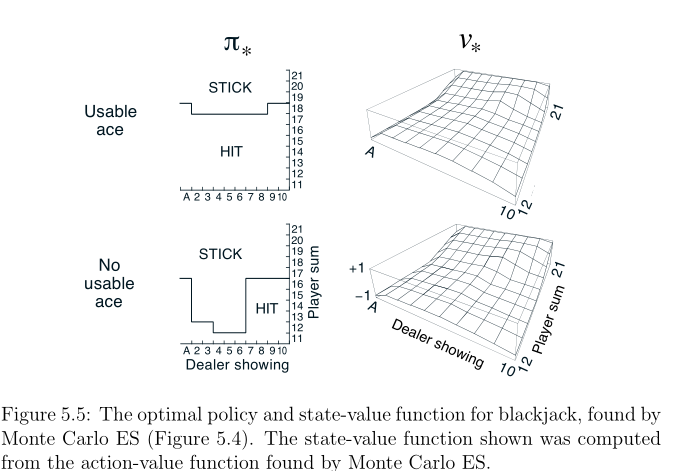

In [49]:
def on_policy_every_visit_MC(env: init_env, N = 1, gamma = 1):

    for _ in tqdm(range(N)):
        state   = env.reset()
        state_reward_trajectory = []
        
        while True:
            action              = env.sample_action_policy(state)
            state_action        = state + (action,)
            state, reward, done = env.step(action)
            state_reward_trajectory.append((state_action, reward))
 
            if done: break
        
        G = 0
        for state_action, reward in reversed(state_reward_trajectory):
            G = gamma*G + reward
            env.Qsa[state_action] = update_mean_single(env.Qsa[state_action], env.num_state_visits[state_action], G)
            env.num_state_visits[state_action] += 1
            
        for state_action,_ in state_reward_trajectory:
            state = state_action[:-1]
            best_action = env.best_action(state)
            env.update_policy_soft(state, best_action)

    return

In [36]:
BJv2 = init_env('Blackjack-v1', sab=True)
BJv2.get_policy_soft()
BJv2.get_Qsa(random = False, val = 0);

100%|██████████| 1000000/1000000 [06:48<00:00, 2447.01it/s]


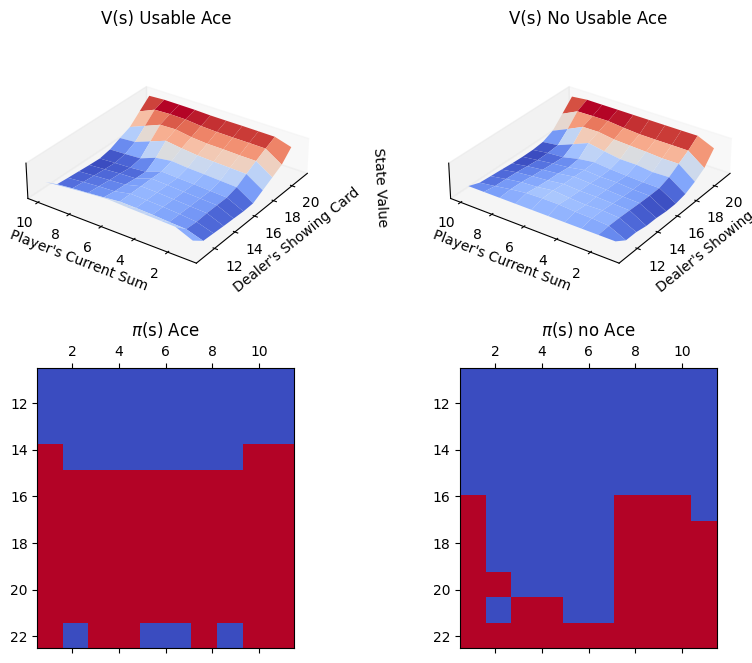

In [66]:
on_policy_every_visit_MC(BJv2,1_000_000)
vp = BJv2.Qsa.max(axis = -1)
min_hand = 11; max_hand = 22; min_deal = 1; max_deal = 11
v_ace, v_ace_no = vp[:,:,0],vp[:,:,1]

pol_ace_no     = np.argmax(BJv2.policy, axis=-1)[:,:,0]
pol_ace        = np.argmax(BJv2.policy, axis=-1)[:,:,1]

plot(v_ace, v_ace_no, pol_ace, pol_ace_no, extent= [min_hand,max_hand,min_deal,max_deal])

# <b>Policy-evaluation (Prediction)</b>:
## Incremental off-policy every-visit MC algorithm

Off-policy prediction allows to construct an estimate of $q_\pi(s,a)$ for policy $\pi$ based on episodes that were recorded by following other policy $\mu$.

This requires for policy $\mu$ to occasionally perform same actions as $\pi$ (called <i>assumption of coverage</i>), which can be done if policy $\mu$ is exploratory.


*   For target policy lets take on-policy every-visit MC result
*   For behavior policy $\mu$ we take random stochastic epsilon policy

[RL Chapter 5 Part4 (Importance sampling in off-policy Monte-Carlo methods of reinforcement learning)](https://www.youtube.com/watch?v=sYfnf6pvioA)

***
Importance sampling allows to estimate expected value, of a random variable with one distribution $x \sim \pi$, by sampling other distribution $x \sim \mu$. 
$$\mathbb{E}_\pi[X] = \sum_x x \cdot \pi(x) = \sum_x \left(x \frac{\pi(x)}{\mu(x)}\right) \cdot \mu(x) = \mathbb{E}_\mu \left[X \frac{\pi(X)}{\mu(X)}\right] $$
This shows that you can get estimate mean value of $\pi$ by scaling samples generated from $\mu$ with so-called <i> likelihood ratio</i>
$$\rho(x) = \frac{\pi(x)}{\mu(x)} = \frac{p(X = x| \pi)}{p(X = x| \mu)}$$ 
Rough idea, is that if sample $x$ has a lower likelihood of emerging from $\mu$ than from $\pi$, then the ratio:
$$\rho(x) \gt 1$$
Thus the weight of sample $x$, coming from $\mu$, is 'boosted' to compensate in difference in distributions.

This can be extended to expectations of functions of random variable:
$$\mathbb{E}_\pi[h(X)] = \mathbb{E}_\mu \left[h(X) \frac{\pi(X)}{\mu(X)}\right] $$
And to conditioning:
$$\mathbb{E}_\pi[h(X)|Y] =  \mathbb{E}_\mu \left[h(X) \frac{\pi(X)}{\mu(X)}\bigg|Y\right] $$
***

Since in MC RL we are estimating $V(s)$ as a sum of discounted values $G$ for each state $s$, we can apply importance sampling there.

What is the likelihood associated with getting reward $G_T$ at episode terminal time $T$, given you start at some time $t$? And is it different for different policies?

We know that it is a chain (Markov Chain) of probabilistic events, a trajectory of states, actions and rewards:
$$S_t,A_t, R_t, S_{t+1}, A_{t+1}, \dots, R_T, S_T$$
And probability of getting from $S_t$ to state $S_{t+1}$ via chain of intermediate actions is:

$$P(A_t, R_t, S_{t+1}|S_t,A_t\sim \pi, R_t) = \pi(A_t|S_t)P(S_{t+1},R_{t+1}|S_t, A_t)$$
Via Markov property there is no history and for second piece of chain
$$P(A_{t+1}, R_{t+1}, S_{t+2}|S_{t+1},A_{t+1}\sim \pi, R_{t+1}) = \pi(A_{t+1}|S_{t+1})P(S_{t+2},R_{t+2}|S_{t+1}, A_{t+1})$$
and transition from state $S_t$ to state $S_{T}$ can be describe as
$$P(A_t, R_t, S_{t+1}, A_{t+1}, \dots, R_T, S_T|S_t,A \sim \pi) = \pi(A_t|S_t)P(S_{t+1},R_{t+1}|S_t, A_t)\cdot \pi(A_{t+1}|S_{t+1})P(S_{t+2},R_{t+2}|S_{t+1}, A_{t+1}) \dots=$$
$$=\prod_{k=t}^{T-1}\pi(A_k|S_k)P(S_{k+1},R_{k+1}|S_k, A_k)$$
The ratio of this event under two different policies is
$$\rho(t\rightarrow T) = \frac{P(\dots A \sim \pi) }{P(\dots A \sim \mu)  } = \frac{\prod_{k=t}^{T-1}\pi(A_k|S_k)P(S_{k+1},R_{k+1}|S_k, A_k)}{\prod_{k=t}^{T-1}\mu(A_k|S_k)P(S_{k+1},R_{k+1}|S_k, A_k)}=
\frac{\prod_{k=t}^{T-1}\pi(A_k|S_k)}{\prod_{k=t}^{T-1}\mu(A_k|S_k)}$$
Which is independent of MDP model, but only includes both policies

Roughly speaking we can calculate value state estimate  $V(s)$ as:
$$V(s) = \mathbb{E}_\pi[G_t] = \mathbb{E}_\mu \left[\rho\cdot G_t \right] \propto \sum_t \rho(t\rightarrow T) \cdot G_t =\sum_t \frac{\prod_{k=t}^{T-1}\pi(A_k|S_k)}{\prod_{k=t}^{T-1}\mu(A_k|S_k)} \cdot G_t $$

I dont show how its normalized because it involves lengthy definition of how time steps are stored and used.

It is worth to say that it can be as simple as dividing by number of relevant time steps or by 
$$\sum_t \rho(t\rightarrow T) $$

First, due to unknown/unbounded number of time steps can lead to high variance. Thats why second is preferred, although it is biased towards policy $\mu$ (19:24 of video).

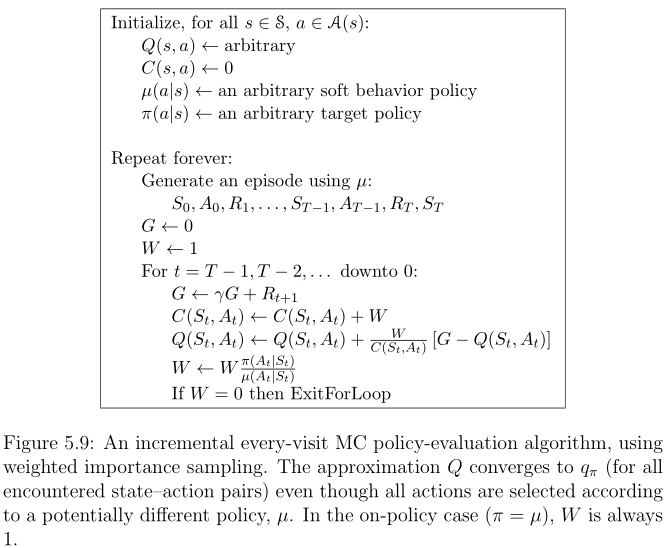

NOTE: 
*   We are going backwards from reward time,
*   at first iteration, for Q(s,a) first (or last?) term in product $\frac{\pi(A_{T-1}|S_{T-1})}{\mu(A_{T-1}|S_{T-1})} = 1/1= W$ is irrelevant, because action is already cast
*   $C(s,a)$ is normalization, in this case counting times

In [73]:
BJoff = init_env('Blackjack-v1', sab=True)
BJoff.get_policy_soft(eps = 0.2);
BJoff.get_Qsa()
BJoff.Csa = defaultdict(float)

In [67]:
def off_policy_every_visit_MC(env: init_env, policy_target, N = 1, gamma = 1):
    for _ in tqdm(range(N)):
        
        state   = env.reset()
        state_reward_trajectory = []
        (W,G)   = (1,0)

        while True:
            action                  = env.sample_action_policy(state)
            state_action            = state + (action,)
            state,  reward, done    = env.step(action)
            state_reward_trajectory.append((state_action, reward))
            if done: break
        
        for state_action, reward in reversed(state_reward_trajectory):
            G = gamma*G + reward
            env.Csa[state_action] += W
            env.Qsa[state_action] += W/env.Csa[state_action]*(G-env.Qsa[state_action])
            W *= policy_target[state_action]/env.policy[state_action]

            if W < 0.0001: 
                #print('break')
                break
    return

100%|██████████| 1000000/1000000 [05:15<00:00, 3171.87it/s]


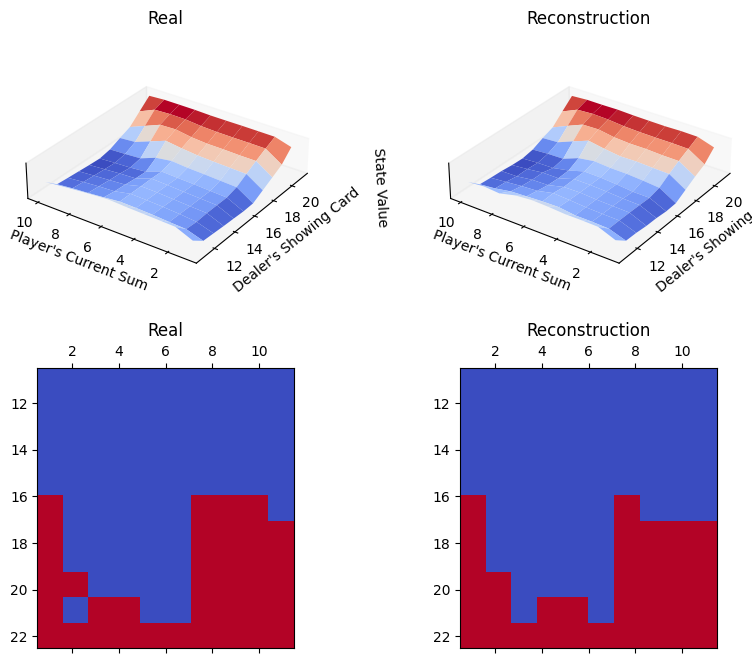

In [83]:
off_policy_every_visit_MC(BJoff,BJ.policy, 1_000_000);
val_OG  = BJv2.Qsa.max(axis = -1)
val_REC = BJoff.Qsa.max(axis = -1)
pol_OG  = np.argmax(BJv2.Qsa, axis=-1)
pol_REC = np.argmax(BJoff.Qsa, axis=-1)
lb1 = ['Real','Reconstruction']
lb2 = ['Real','Reconstruction']
plot(val_OG[:,:,0], val_REC[:,:,0], pol_OG[:,:,0], pol_REC[:,:,0], extent= [min_hand,max_hand,min_deal,max_deal],lables1=lb1, lables2=lb2)

# Off-policy every-visit MC control
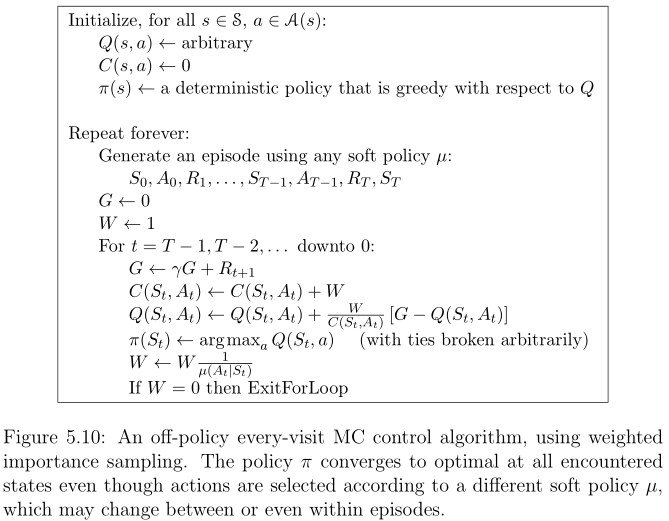

https://www.youtube.com/watch?v=6-OU-c1fUlY

In [42]:
np.random.seed(69)

Qsa         = np.random.randn(*Qsa_backup.shape)
Csa         = np.zeros_like(Qsa)
policy      = np.argmax(Qsa, axis=-1)
policy_soft = policy_backup.copy()

def off_policy_every_visit_MC_control(environment, N = 1):
    env = environment
    for _ in range(N):
        state = env.reset()[0]          # get initial state
        state = tuple(map(int,state))   # map has_ace to int
        trajs   = []                    # trajectories for an episode
        rewards = []                    # rewards for an episode
        (W,G)   = (1,0)
        while True:
            pol     = policy_soft[state]                # policy for that state p(a|s)
            action  = np.random.choice(actions, p = pol)# sample action from policy
            state_action = state + (action,)            # staring from s doing a, get reward on new state
            trajs.append(state_action)                  # add state  to episode trajs
            #print(state,'action:',action,end = '->')
            state, reward, done = env.step(action)[:3]  # make action, observe returns
            rewards.append(reward)                      # add reward to episode rewards
            state = tuple(map(int,state))
            #print(state, done)
            # NOTE: i stagger states and rewards, so state-action at t=i is matched
            # NOTE: with reward at t = i + 1 and dont include terminal state.

            if done:
                #print('Trajectory:',trajs,' Rewards',rewards, '\n')
                break
        for sa, r in zip(reversed(trajs), reversed(rewards)):
            s = sa[:-1]
            G = gamma*G + r
            Csa[sa] += W
            Qsa[sa] = Qsa[sa] + W/Csa[sa]*(G-Qsa[sa])
            policy[s] = Qsa[s].argmax() 
            W *= 1/policy_soft[sa]

            if W < 0.0001: 
                print('break')
                break

    return Qsa

off_policy_every_visit_MC_control(env, 500_000);

In [50]:
env_CW = gym.make("CliffWalking-v0")
env_CW.observation_space.n

48

In [64]:
a = np.ones((10,2))
len(a)

10